In [1]:
import requests as req
import pandas as pd
import numpy as np
import matplotlib as mat
from matplotlib import pyplot as plt

# Анализ данных

Для удобства в первую очередь проверю все гипотезы на одном чарте, в дальнейшем проверю на остальных

In [2]:
week_charts = pd.read_csv('data_sets\week_charts_features.csv')

Гипотезы и цели:
1. Треки из глобального чарта равномерно распределены по чартам стран
2. Выяснить долю и популярность локальных исполнителей
3. Разделить страны на кластеры по предпочтениям жанров и атрибутов музыки

Поздно понял что место трека в чарте полезная информация

In [3]:
position = np.arange(1, 51)
countrs = week_charts.country.unique()
iterabli = [countrs, position]
idx = pd.MultiIndex.from_product(iterabli, names=['country', 'place'])

In [4]:
week_place = week_charts.set_index(idx) \
            .drop('country', axis=1) \
            .reset_index()

## 1. Насколько чарты стран схожи с глобальным чартом

Формирую глобальный и локальные чарты

In [5]:
global_chart = week_place[week_place.country == 'во всем мире'][['place', 'name']]
global_chart.head(3)

,place,name
0,1,Heat Waves
1,2,STAY (with Justin Bieber)
2,3,Enemy (with JID) - from the series Arcane Leag...


In [6]:
country_charts = week_place[week_place.country != "во всем мире"][['country', 'place', 'name']]
country_charts.head(3)

,country,place,name
50,Австралия,1,Heat Waves
51,Австралия,2,STAY (with Justin Bieber)
52,Австралия,3,Cold Heart - PNAU Remix


Фрейм с треками и их позициями, которые есть в глобальном и локальных чартах

In [7]:
similarity = pd.merge(country_charts, global_chart, on='name', how='inner', suffixes=['_in_global', '_in_local'])
similarity.head(3)

,country,place_in_global,name,place_in_local
0,Австралия,1,Heat Waves,1
1,Австрия,1,Heat Waves,1
2,Бельгия,3,Heat Waves,1


Добавил две метрики:  
Средняя позиция треков глобольного чарта в локальном  

Стандартное отклонение разницы позиции трека в глобальном и локальных чартах  
Иными словами - на сколько в среднем позиция трека в локальном чарте отличается от позиции в глобальном

In [8]:
result = similarity.copy()
result['diff'] = result.place_in_local - result.place_in_global
result.sort_values('country')
result = result.groupby('country') \
                .agg(
                    amount=('name', 'count'),
                    average_place_in_local=('place_in_local', lambda x: np.around(np.mean(x), 2)),
                    std=('diff', 'std')
                )
result = result.sort_values('amount', ascending=0)

In [14]:
result

,amount,average_place_in_local,std
country,,,
ОАЭ,35,22.80,7.476911
Канада,34,22.03,13.569685
Австралия,31,21.84,10.281207
Швейцария,27,17.59,11.830835
США,27,21.04,13.726262
Ирландия,26,19.08,12.679299
Австрия,25,18.56,10.388776
Чехия,24,17.83,11.813696
Словакия,24,17.62,13.142199


<AxesSubplot:>

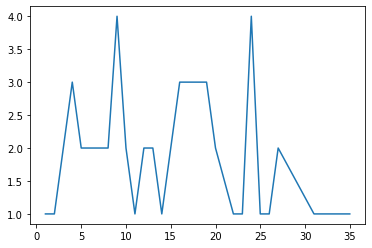

In [13]:
result.amount.value_counts().sort_index().plot()

## Исполнители попавшие в наибольшее число чартов 

In [6]:
week_place.groupby('artist') \
    .agg({'artist':'count', 'place':np.mean}) \
    .rename(columns={'artist':'times_in_charts'}) \
    .sort_values('times_in_charts', ascending=False)

,times_in_charts,place
artist,,
Bad Bunny,75,28.026667
Ed Sheeran,64,23.578125
Lil Nas X,54,22.203704
Imagine Dragons,42,20.000000
Glass Animals,38,11.736842
...,...,...
Kaan Boşnak,1,26.000000
Kacperczyk,1,27.000000
Kaleb J,1,16.000000
